In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
# Updated import for Keras Tuner
from keras_tuner import HyperModel, RandomSearch

# Assuming dataset_folder is defined and points to your dataset directory
dataset_folder = 'C:\\Users\\Alexandra\\Documents\\SPRING_2024\\BMEN_689\\Project_2\\Jupyter_Notebook\\512x512_Phage_EMs\\'

# Function to split dataset into train/validation/test
def split_dataset(data_folder, train_size=0.6, val_size=0.2, test_size=0.2):
    for class_folder in os.listdir(data_folder):
        class_path = os.path.join(data_folder, class_folder)
        if os.path.isdir(class_path):
            files = os.listdir(class_path)
            train_files, test_files = train_test_split(files, test_size=val_size+test_size, random_state=42)
            val_files, test_files = train_test_split(test_files, test_size=test_size/(val_size+test_size), random_state=42)

            train_folder = os.path.join(data_folder, 'train', class_folder)
            val_folder = os.path.join(data_folder, 'validation', class_folder)
            test_folder = os.path.join(data_folder, 'test', class_folder)
            for folder in [train_folder, val_folder, test_folder]:
                if not os.path.exists(folder):
                    os.makedirs(folder)

            for file in train_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(train_folder, file))
            for file in val_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(val_folder, file))
            for file in test_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(test_folder, file))

# Call the function to split the dataset
split_dataset(dataset_folder)

class ConvolutionalHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        
    def build(self, hp):
        model = models.Sequential()
        model.add(layers.Conv2D(
            filters=hp.Choice('filters_0', [32, 64, 128, 256]),
            kernel_size=(3, 3),
            activation='relu',
            input_shape=self.input_shape))
        model.add(layers.MaxPooling2D((2, 2)))
        
        # Convolutional layers
        for i in range(1, hp.Int('num_conv_layers', 2, 5)):
            model.add(layers.Conv2D(
                filters=hp.Choice(f'filters_{i}', [32, 64, 128, 256]),
                kernel_size=(3, 3),
                activation='relu'))
            model.add(layers.MaxPooling2D((2, 2)))
        
        model.add(layers.Flatten())
        
        # Correctly configuring Dense layers based on hyperparameters
        for i in range(hp.Int('num_dense_layers', 1, 3)):
            model.add(layers.Dense(
                units=hp.Choice(f'units_dense_{i}', [32, 64, 128, 256]),
                activation='relu'))
            # Ensuring dropout layers are correctly added based on hyperparameters
            if hp.Boolean(f'dropout_{i}'):
                model.add(layers.Dropout(hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.5, step=0.1)))
        
        model.add(layers.Dense(self.num_classes, activation='softmax'))
        
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

input_shape = (512, 512, 3)  # Use 3 channels for RGB images
num_classes = 3

hypermodel = ConvolutionalHyperModel(input_shape, num_classes)

# Define directory paths
train_dir = os.path.join(dataset_folder, 'train')
validation_dir = os.path.join(dataset_folder, 'validation')
test_dir = os.path.join(dataset_folder, 'test')

# Load in images with color_mode='rgb'
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

batch_size = 32
target_size = (512, 512)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',  # Load images in RGB
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',  # Load images in RGB
    class_mode='categorical')

# Initialize the Random Search tuner
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='cnn_tuning'
)

# Execute the search
tuner.search(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10
)

# After tuning, retrieve the best model and print its summary
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Trial 10 Complete [00h 04m 08s]
val_accuracy: 0.59375

Best val_accuracy So Far: 0.59375
Total elapsed time: 00h 47m 56s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 255, 255, 256)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 64)      147520    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 126, 126, 64)      0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1016064)           0         
 

Found 186 images belonging to 3 classes.
Found 63 images belonging to 3 classes.
Epoch 1/10
5/5 [==============================] - 26s 5s/step - loss: 5562.9014 - accuracy: 0.3442 - val_loss: 1.2164 - val_accuracy: 0.3438
Epoch 2/10
5/5 [==============================] - 25s 5s/step - loss: 1.0984 - accuracy: 0.4156 - val_loss: 0.9756 - val_accuracy: 0.3750
Epoch 3/10
5/5 [==============================] - 25s 5s/step - loss: 1.0442 - accuracy: 0.4675 - val_loss: 1.0240 - val_accuracy: 0.5625
Epoch 4/10
5/5 [==============================] - 25s 5s/step - loss: 1.0254 - accuracy: 0.4610 - val_loss: 0.9424 - val_accuracy: 0.5312
Epoch 5/10
5/5 [==============================] - 25s 5s/step - loss: 0.9617 - accuracy: 0.4935 - val_loss: 0.9946 - val_accuracy: 0.4688
Epoch 6/10
5/5 [==============================] - 24s 5s/step - loss: 0.9495 - accuracy: 0.5065 - val_loss: 1.3107 - val_accuracy: 0.4688
Epoch 7/10
5/5 [==============================] - 25s 5s/step - loss: 0.9006 - accuracy:

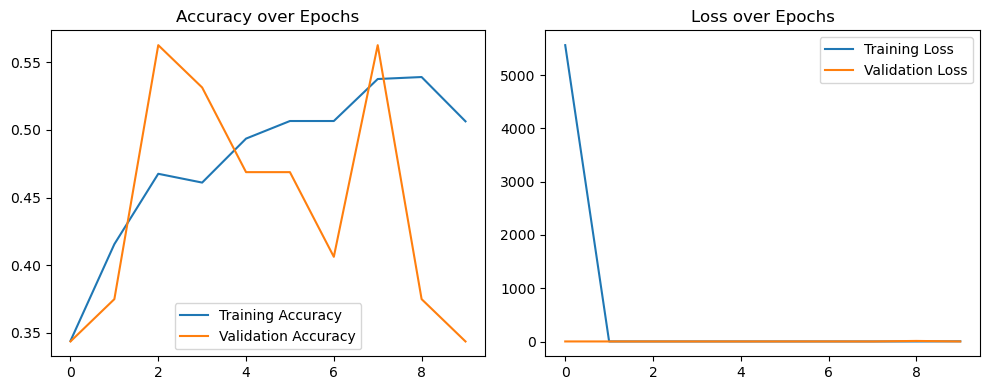

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Assuming dataset_folder is defined and points to your dataset directory
dataset_folder = 'C:\\Users\\Alexandra\\Documents\\SPRING_2024\\BMEN_689\\Project_2\\Jupyter_Notebook\\512x512_Phage_EMs\\'

# Function to split dataset into train/validation/test
def split_dataset(data_folder, train_size=0.6, val_size=0.2, test_size=0.2):
    for class_folder in os.listdir(data_folder):
        class_path = os.path.join(data_folder, class_folder)
        if os.path.isdir(class_path):
            files = os.listdir(class_path)
            train_files, test_files = train_test_split(files, test_size=val_size+test_size, random_state=42)
            val_files, test_files = train_test_split(test_files, test_size=test_size/(val_size+test_size), random_state=42)

            train_folder = os.path.join(data_folder, 'train', class_folder)
            val_folder = os.path.join(data_folder, 'validation', class_folder)
            test_folder = os.path.join(data_folder, 'test', class_folder)
            for folder in [train_folder, val_folder, test_folder]:
                if not os.path.exists(folder):
                    os.makedirs(folder)

            for file in train_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(train_folder, file))
            for file in val_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(val_folder, file))
            for file in test_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(test_folder, file))

# Call the function to split the dataset
split_dataset(dataset_folder)

input_shape = (512, 512, 3)  # Use 3 channels for RGB images
num_classes = 3

# Initialize the model
model = models.Sequential()

# First convolutional layer with the hyperparameters found
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer with the hyperparameters found
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output to feed into the dense layers
model.add(layers.Flatten())

# First dense layer with the hyperparameters found
model.add(layers.Dense(units=32, activation='relu'))

# Output layer with the number of classes
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define directory paths
train_dir = os.path.join(dataset_folder, 'train')
validation_dir = os.path.join(dataset_folder, 'validation')

# Load in images with color_mode='rgb'
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

batch_size = 32
target_size = (512, 512)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',  # Load images in RGB
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',  # Load images in RGB
    class_mode='categorical')

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10
)

# Plot training and validation accuracy and loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.tight_layout()
plt.show()

In [7]:
# Evaluate the model on the test set if you want to see the final performance
test_dir = os.path.join(dataset_folder, 'test')  # Make sure this is the correct path to your test set
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test accuracy:', test_accuracy)

Found 63 images belonging to 3 classes.
1/1 [==============================] - 1s 1s/step - loss: 1.4923 - accuracy: 0.4375
Test accuracy: 0.4375
